# Вариант 2

Загрузить файлы и информацией о лицах, перевести в тензорный формат и построить модель классификации.

In [149]:
import numpy as np
from PIL import Image

images = np.load('olivetti_faces.npy')  # при необходимости укажите свой

Выведем форму произвольного изображения:

In [150]:
images[359].shape

(64, 64)

Выведем произвольное изображение из датасета

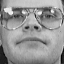

In [151]:
im = Image.fromarray(images[359] * 256)
new_im = im.convert('RGB')

display(new_im)

In [152]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import metrics
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
import matplotlib.pyplot as plt

In [153]:
class FacesDataset(Dataset):

    def __init__(self, mean, std):
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])

        # уменьшим время обучения однократным применением transform
        self.data = torch.vstack([self.transform(i) for i in np.load("olivetti_faces.npy")]).unsqueeze(1)
        self.targets = torch.from_numpy(np.load("olivetti_faces_target.npy")).to(torch.long)
        self.n_classes = self.targets.unique().size(0)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [154]:
dataset = FacesDataset(mean=(0.5,), std=(0.5,))  # попробуем с константами, если успею, посчитаю правильные значения
# кол-во классов очень большое для такой маленькой выборки
dataset.data.size(), dataset.targets.size(), dataset.n_classes

(torch.Size([400, 1, 64, 64]), torch.Size([400]), 40)

In [155]:
torch.manual_seed(0)
# взял разделение 70/30 - завышаю test_size, что бы не радоваться не настоящим результатам из-за маленького теста
train_size = round(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, lengths=(train_size, test_size))
len(train_dataset), len(test_dataset)

(280, 120)

In [156]:
class FacesClassificator(nn.Module):

    def __init__(self, in_channels, n_classes):
        super().__init__()
        out_channels = 32  # был 1 канал (чб изображение) - найду 32 полезных канала, возможно можно меньше
        width, height = 6, 6
        self.features = nn.Sequential(
            # свертка с обычными параметрами
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # сжатие в 2 раза
            nn.MaxPool2d(2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((width, height))  # что бы не считать размеры выхода features слоя
        self.classifier = nn.Sequential(
            nn.Linear(out_channels * width * height, 128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(128, n_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

In [157]:
torch.manual_seed(0)

net = FacesClassificator(1, dataset.n_classes)
loss_fn = nn.CrossEntropyLoss()
# после нескольких запусков с 0.01, 0.001, заметил,
# что точность модели сильно изменяется от эпохи к эпохе
# решил уменьшить скорость обучения до 0.0005
optimizer = optim.Adam(net.parameters(), lr=0.0005)

# пробовал batch_size={8,4} - оба хороши
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
# картинок, мало и они маленькие, для теста можно положить в память все
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

net

FacesClassificator(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=1152, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=40, bias=True)
  )
)

In [158]:
epochs = 50  # путем нескольких запусков начиная с epochs = 10 пришел с 50

train_losses = []
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n" + "-" * 32)
    # ************* train loop
    net.train()
    size = len(train_dataloader.dataset)
    num_batches = len(train_dataloader)
    avg_loss = 0
    for batch, (x, y) in enumerate(train_dataloader):
        pred = net(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss
        if batch % 30 == 0:
            print(f"loss: {loss:>7f}  [{batch * len(x):>5d}/{size:>5d}]")

    train_losses.append((avg_loss / num_batches).item())

    # ************* test loop
    net.eval()
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    avg_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in test_dataloader:
            pred = net(x)
            avg_loss += loss_fn(pred, y)
            correct += (pred.argmax(1) == y).sum().item()

    avg_loss /= num_batches
    accuracy = correct / size
    print(f"Test Error: \n Accuracy: {accuracy:>4f}, Avg loss: {avg_loss:>8f} \n")

Epoch 1
--------------------------------
loss: 3.766706  [    0/  280]
loss: 3.588421  [  240/  280]
Test Error: 
 Accuracy: 0.033333, Avg loss: 3.677421 

Epoch 2
--------------------------------
loss: 3.690583  [    0/  280]
loss: 3.405414  [  240/  280]
Test Error: 
 Accuracy: 0.050000, Avg loss: 3.582410 

Epoch 3
--------------------------------
loss: 3.300273  [    0/  280]
loss: 3.616802  [  240/  280]
Test Error: 
 Accuracy: 0.141667, Avg loss: 3.436419 

Epoch 4
--------------------------------
loss: 3.271664  [    0/  280]
loss: 3.328219  [  240/  280]
Test Error: 
 Accuracy: 0.166667, Avg loss: 3.292342 

Epoch 5
--------------------------------
loss: 2.963363  [    0/  280]
loss: 3.601423  [  240/  280]
Test Error: 
 Accuracy: 0.200000, Avg loss: 3.133747 

Epoch 6
--------------------------------
loss: 2.989193  [    0/  280]
loss: 2.851480  [  240/  280]
Test Error: 
 Accuracy: 0.225000, Avg loss: 3.032674 

Epoch 7
--------------------------------
loss: 2.951918  [    0/

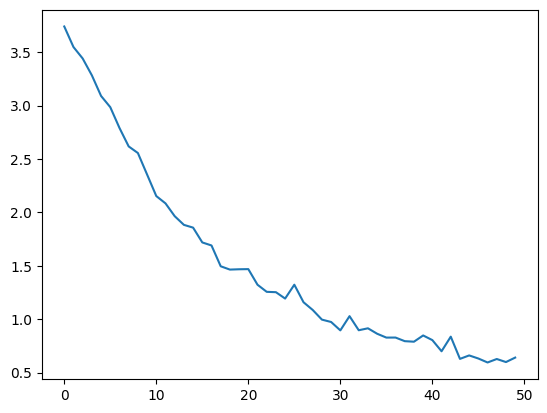

In [159]:
plt.plot(torch.arange(len(train_losses)), train_losses);

In [160]:
net.eval()

x_test, y_test = next(iter(test_dataloader))
y_pred = net(x_test).argmax(1)
print(metrics.classification_report(y_true=y_test, y_pred=y_pred, zero_division=True))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      0.75      0.86         4
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         3
           6       0.75      1.00      0.86         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         4
           9       0.80      1.00      0.89         4
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         4
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         4
          15       1.00      0.80      0.89         5
          16       1.00      1.00      1.00         4
          17       1.00    


**Вывод.** Такая хорошая точность не означает успех обучения модели. Она получилась из-за очень маленького количества данных в тестовой выборке - по 2-5 примеров на класс.

# Отчетность

В первую очередь в работе должна быть продемонстрирована ваша архитектура и процесс обучения (с кратким обоснованием выбора гиперпараметров).


Далее:

(В конце вашего ноутбука укажите следующие данные)

По задачам классификации:

1.  Вывести метрики классификации на тестовом множестве: accuracy, precision, recall и f1-score(для бинарной) и метрик качества для каждого класса, в случае использования датасета с лицами.
2.  Обосновать выбранное соотношение train/test на основе построения кривых обучения (или понятного вывода результатов эксперимента) 



По задаче регрессии:



1.   Вывести коэффициент детерминации и средний квадрат ошибки
2.   Продемнострировать, что выбрано оптимальное соотношение train/test, путем перебора всех содержательных вариантов.

